<a href="https://colab.research.google.com/github/dagousket/ML-course-VIB-2020/blob/master/notebooks/Histone_marks_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histone modifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

[PyCaret](https://pycaret.org/) is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

It is not available by default, so we first install the library.

In [ ]:
! pip install pycaret

# 1. The data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [15]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_test.csv")

Let's look at a random sample of the training set:

In [16]:
train.sample(20)

GeneId  H3K4me3_0  H3K4me1_0  ...  H3K9me3_99  H3K27me3_99  Label
9253    3519          9          2  ...           0            2      0
7056    9434          1          7  ...           6            1      1
4818    9236          1          1  ...           1            3      1
5844   12870          1          0  ...           0            0      0
6480   13929          0          1  ...           2            1      1
2460   10463          2          2  ...           2            3      1
5920    3551          6          2  ...           5            0      1
2381    5724          0          0  ...           3            3      0
194    10825          0          1  ...           1            1      1
8064    2593          2          0  ...           2            2      1
267     1682          0          1  ...           0            0      1
4168   15317          2          2  ...           0            1      1
2852    6106          2          0  ...           3            0      1
9640    4555          0          1  ...           3            2      1
6803   10857          1          0  ...           0            0      1
3319    9009          1          1  ...           0            0      0
6506     378          5          2  ...           4            0      1
6710    3964          0          1  ...           0            0      0
9222    3659          0          3  ...           2            1      0
2553    7837          3          0  ...           1            0      0

[20 rows x 502 columns]

An alternative visualization for this type of counting data is the heatmap.

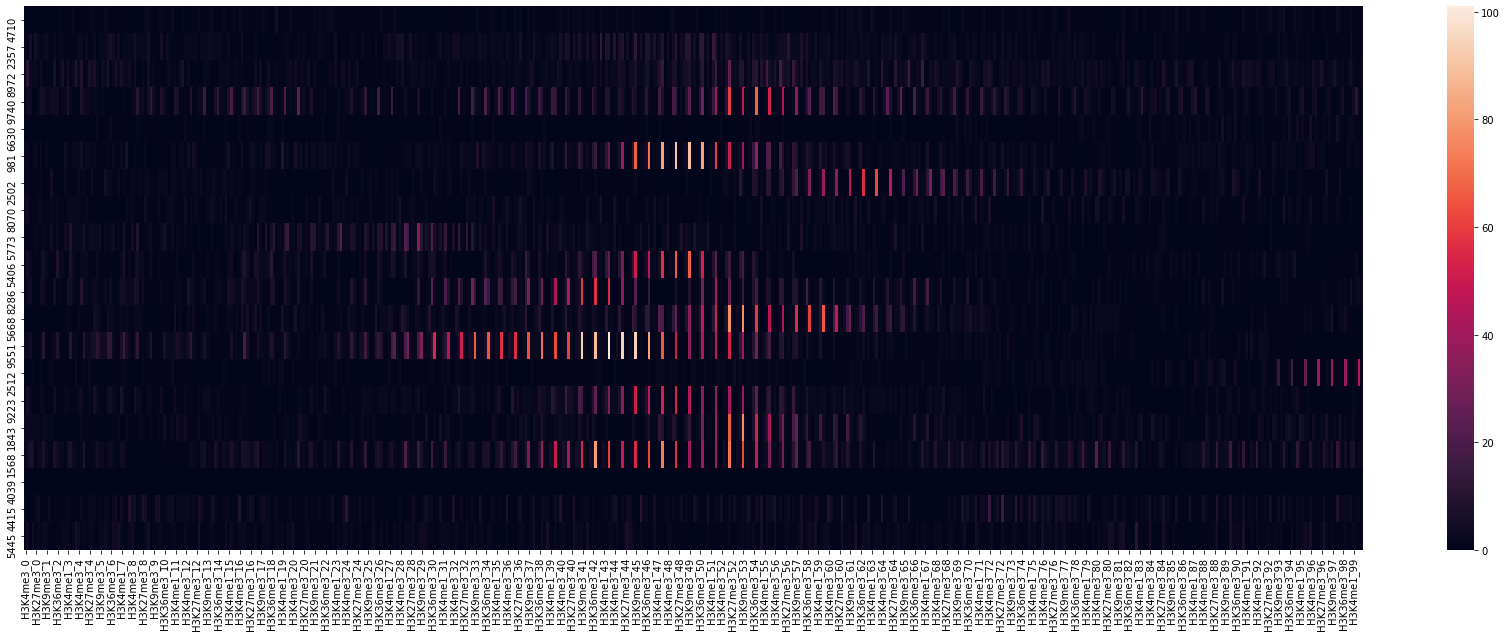

In [19]:
import seaborn as sns

plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

The label for each datapoint is in the `Label` column.

In [18]:
train_labels = train.pop("Label")
train_index_col = train.pop("GeneId")

Now `train` contains the feature columns only.

Let's look at the number datapoints in each class:

In [14]:
train_labels.value_counts()

2047     1
13508    1
11495    1
13540    1
1250     1
        ..
12859    1
8761     1
10808    1
6710     1
4098     1
Name: GeneId, Length: 10436, dtype: int64

Let's look at `test`:

In [20]:
test.head(5)

GeneId  H3K4me3_0  H3K4me1_0  ...  H3K36me3_99  H3K9me3_99  H3K27me3_99
0    5222          2          2  ...            1           1            1
1     891          1          2  ...            5           2            1
2    7219          1          1  ...            1           1            0
3    7225          1          5  ...            0           2            0
4    9432          1         16  ...            1           2            1

[5 rows x 501 columns]

This is a blind test so the `Label` column is not available in the test set. The test set does contain the `GeneId` column that is needed to send your predictions to the Kaggle website.


In [21]:
test_index_col = test.pop("GeneId")

We can compute some decriptive statistics about the training set using the DataFrame `.describe()` function:

In [22]:
train.describe()

H3K4me3_0     H3K4me1_0  ...    H3K9me3_99   H3K27me3_99
count  10436.000000  10436.000000  ...  10436.000000  10436.000000
mean       1.482081      1.738885  ...      1.826945      1.129935
std        1.883112      2.098565  ...      4.924786      1.472372
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        1.000000      1.000000  ...      1.000000      1.000000
75%        2.000000      2.000000  ...      2.000000      2.000000
max       21.000000     24.000000  ...    115.000000     43.000000

[8 rows x 500 columns]

We can plot these descriptive statistics to get a general overview of the data.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


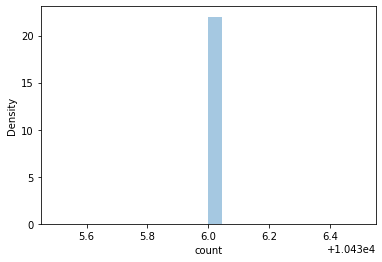

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


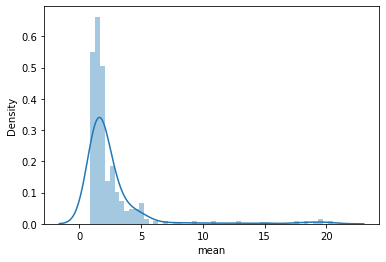

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


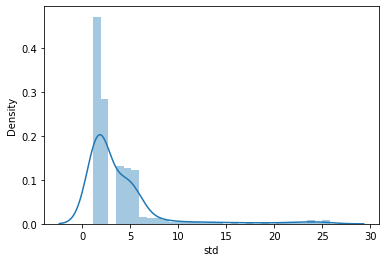

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


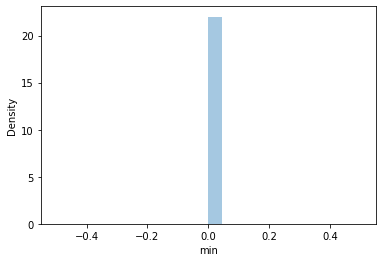

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


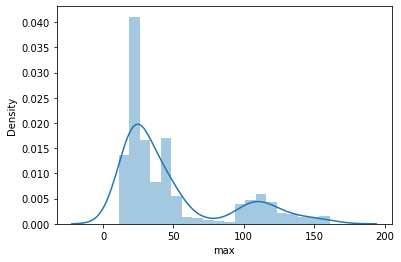

In [23]:
for col in ["count","mean","std","min","max"]:
  sns.distplot(pd.DataFrame(train.describe().transpose())[col])
  plt.show()

We can use the Pandas `boxplot()` function to plot the feature values.

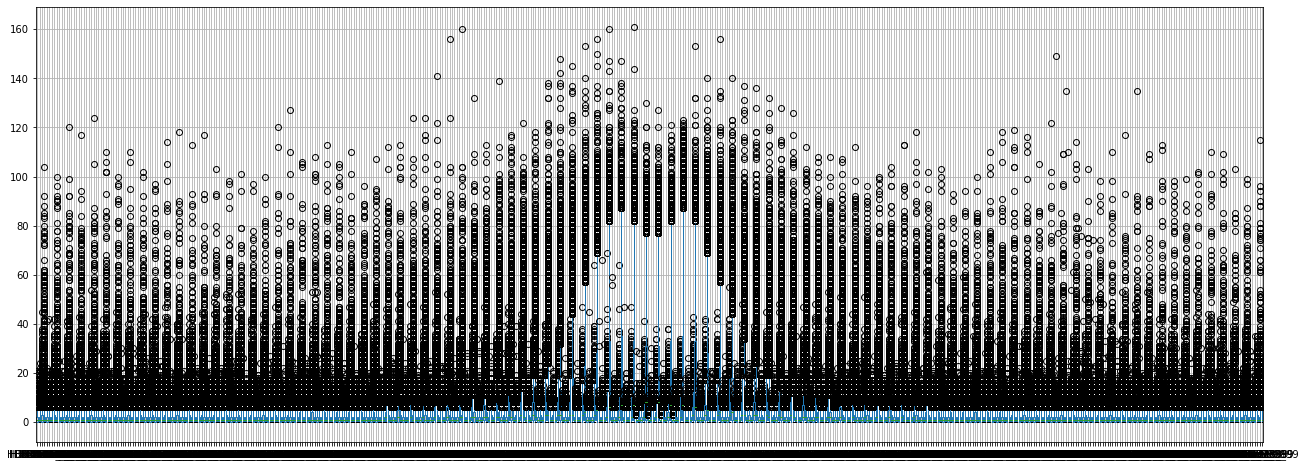

In [24]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.show()

Let's plot these for each hisotone mark.

In [25]:
marks = {}
for m in train.columns:
  marks[m.split("_")[0]] = True
marks = list(marks.keys())
marks

['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

H3K4me3


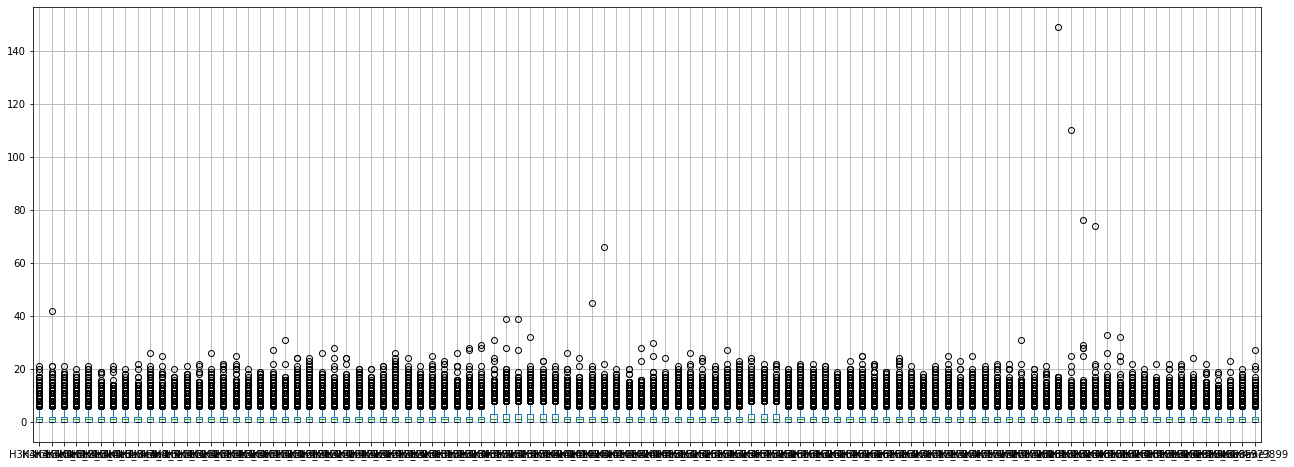

H3K4me1


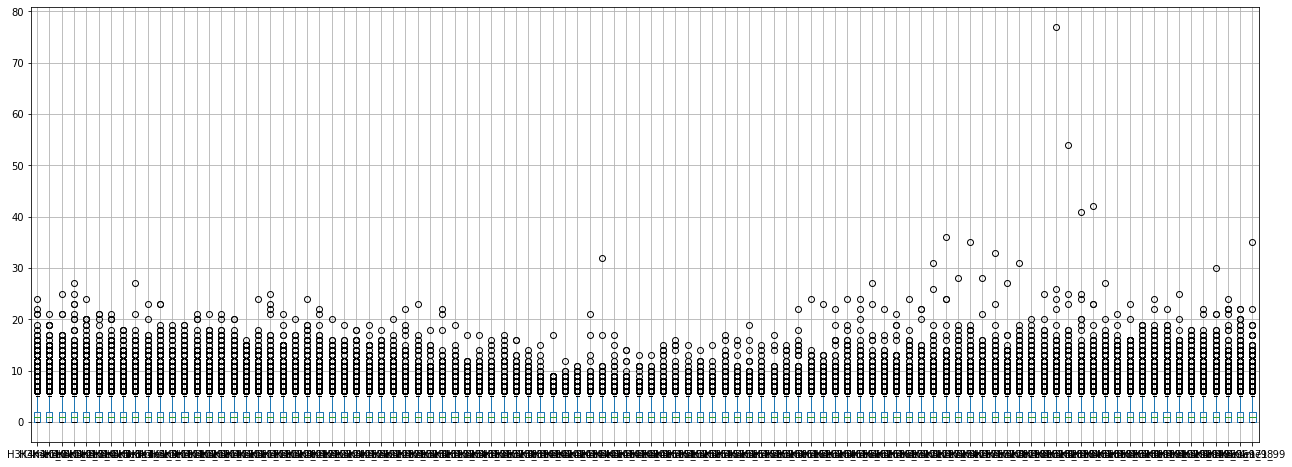

H3K36me3


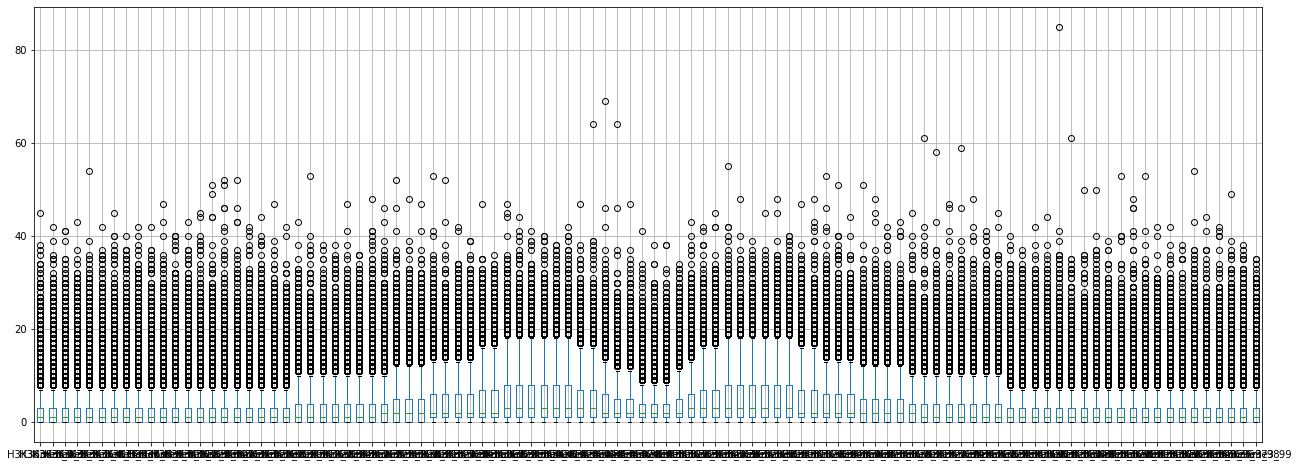

H3K9me3


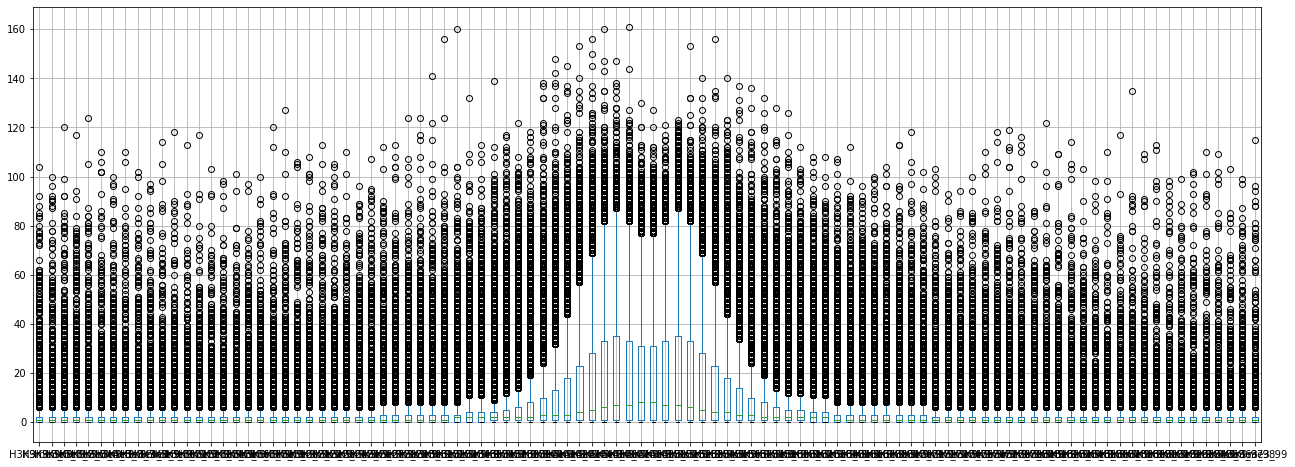

H3K27me3


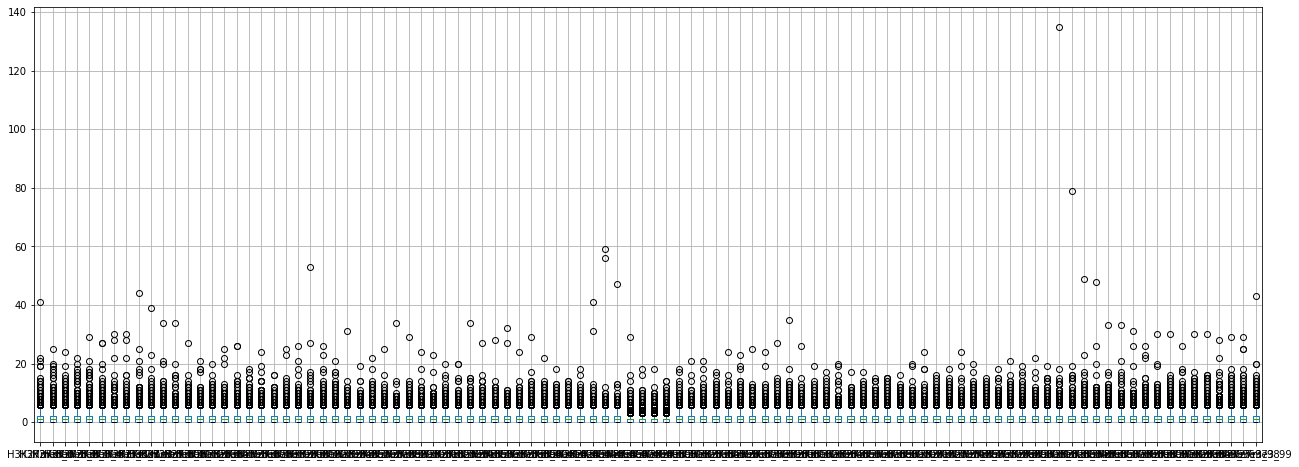

In [26]:
for mark in marks:
  cols = []
  for m in train.columns:
    if mark in m:
      cols.append(m)
  print(mark)
  plt.figure(figsize=(22,8))    
  train[cols].boxplot()
  plt.show()

# 2. Our first model

Let's fit a Logistic Regression model. We will first use the very popular (with good reason) [Scikit-learn](https://scikit-learn.org/stable/) library for that.

First, we hold out 20% if the training data for independant validation.

Next, we fit the modelparameters on the training set and evaluate the fitted model on the validation set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls = LogisticRegression()

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

# 3. How well does it perform in pratice?

In [ ]:
#code for submission
predictions_test = cls.predict(test)

to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = predictions_test
to_write.to_csv("submission1.csv",index=False)

For the Kaggle competition your predictions are not evaluated by accuracy, but by log-loss:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:

In [ ]:
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train),log_loss(val_y,predictions_val)))

# 4. Data pre-processing




Let's scale all the features to [0,1]:

In [27]:
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)
train_norm.head()

H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K36me3_99  H3K9me3_99  H3K27me3_99
0   0.047619   0.041667    0.044444  ...     0.342857    0.017391     0.046512
1   0.000000   0.000000    0.022222  ...     0.000000    0.000000     0.000000
2   0.333333   0.125000    0.022222  ...     0.028571    0.008696     0.000000
3   0.190476   0.083333    0.088889  ...     0.000000    0.000000     0.000000
4   0.047619   0.041667    0.044444  ...     0.028571    0.008696     0.000000

[5 rows x 500 columns]

H3K4me3


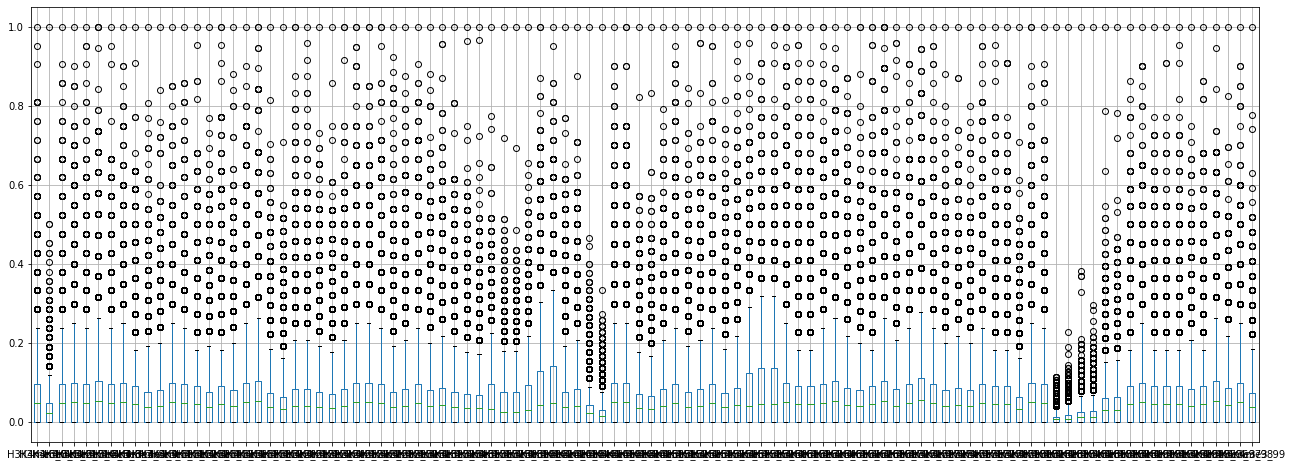

H3K4me1


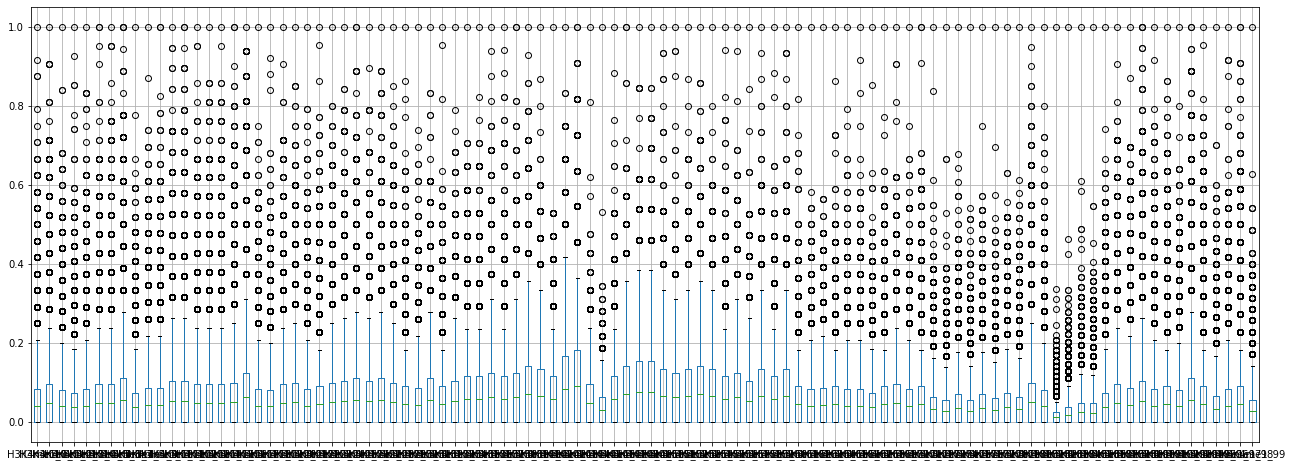

H3K36me3


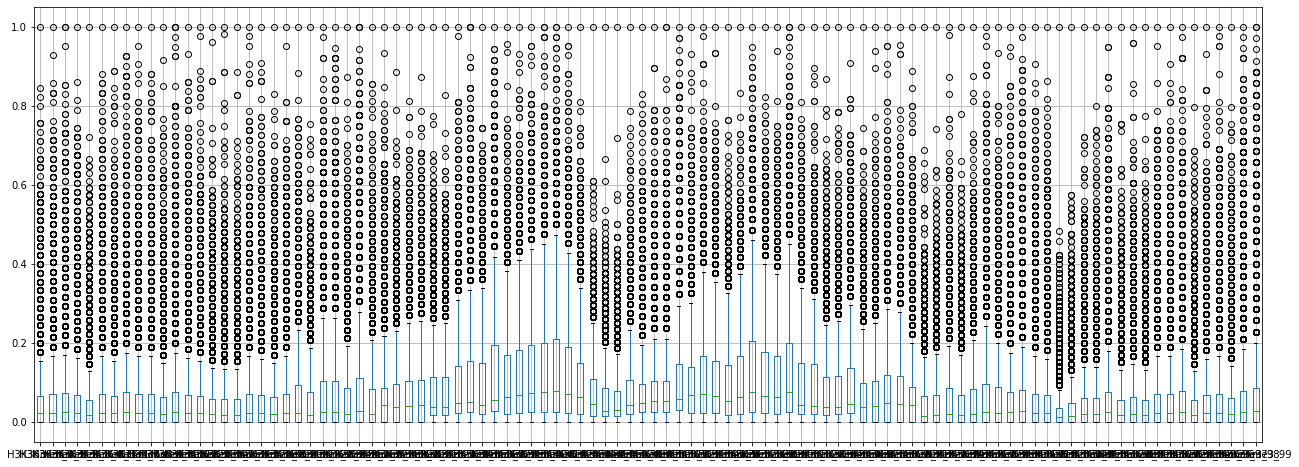

H3K9me3


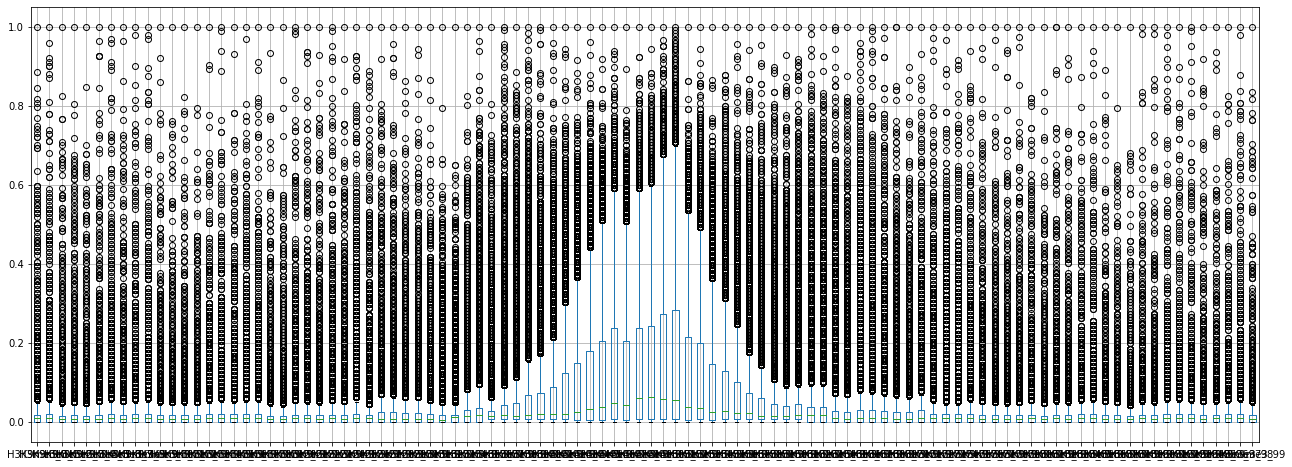

H3K27me3


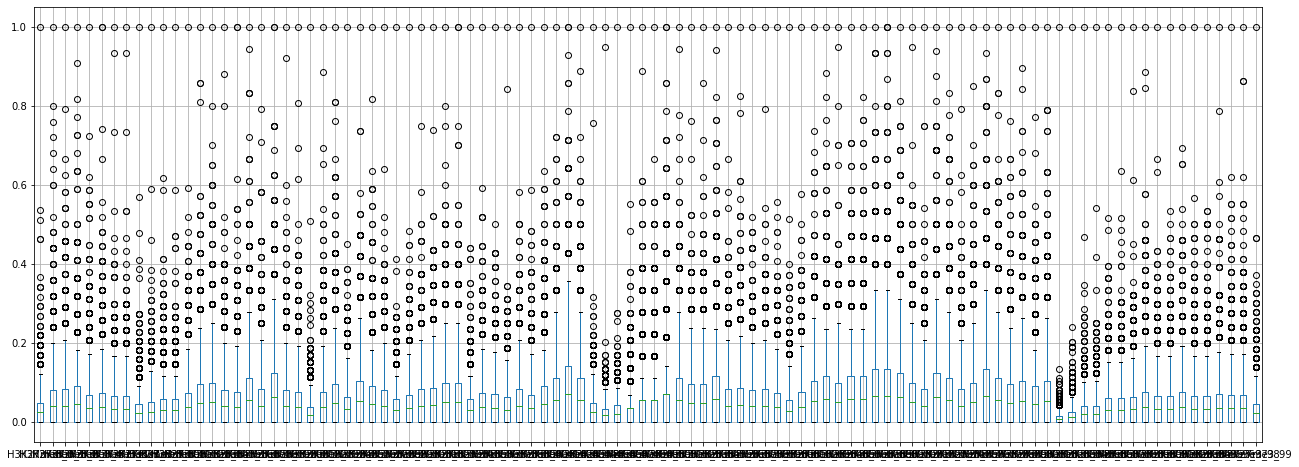

In [28]:
for mark in marks:
  cols = []
  for m in train_norm.columns:
    if mark in m:
      cols.append(m)
  print(mark)
  plt.figure(figsize=(22,8))    
  train_norm[cols].boxplot()
  plt.show()

Now, did we improve the predictions?

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

# 5. Hyperparameter tuning

From now on we will use the PyCaret library for fitting models. It provides many useful functions that make Machine Learning fun.

To use PyCaret we first need to setup an environment that prepares the data for fitting and validation.

In [ ]:
from pycaret.classification import *

train_norm["Label"] = train_labels
setup(data=train_norm,target="Label",numeric_features=list(train.columns)[:-1], train_size=0.8, silent=True)

By default, PyCaret does not compute the log-loss metric. So, we add it.

In [ ]:
from sklearn.metrics import log_loss

add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Next, we fit a model using `create_model` that is similar to `fit()` in Scikit-learn, except that it fits and evaluates (CV) on the 80% fitting part of the training set only. The output of this function is a score grid with CV scores by fold.

In [ ]:
lr = create_model("lr")

We just fitted a Logistic Regression model with a default value of 1.0 for the regularization parameter, as you can see below.

In [ ]:
lr

In [ ]:
result = predict_model(lr)

It is now easy to optimize (tune) this hyperparameter.

In [ ]:
tune_grid = {
    "C": np.linspace(0.0001,10,1000)
    }

tuned_lr = tune_model(lr,tuner_verbose=2, n_iter=10, fold=5, custom_grid=tune_grid)

`tune_model()` applies an random search on the `tune_grid` where each point in the seach space is evaluated using cross-validation:

<br/>
<br/>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"/>
<br/>
<br/>


This is the 'optimal' value for the regularization hyperparameter:

In [ ]:
tuned_lr

We can now again test this model on the validation set.

In [ ]:
result = predict_model(tuned_lr)

PyCaret offers some very useful tools for model validation.

In [ ]:
evaluate_model(tuned_lr)

Finally, we can fit the optimal model on the full training set. 

In [ ]:
final_lr = finalize_model(tuned_lr)

To obtain insight into how the model uses each of the features we can look at the values of the modelparameters.

In [ ]:
tmp = []
for feature, modelparameter in zip(train.columns,final_lr.coef_[0]):
  tmp.append([feature,np.abs(modelparameter)])

tmp = pd.DataFrame(tmp,columns=["feature","modelparameter"])

tmp.sort_values("modelparameter",ascending=False)

And the we can make predictions for the blind test set. PyCaret adds two columns to the test set: Label (the predicted class) and Score (the probability of class 1).

In [ ]:
result = predict_model(final_lr,data=test)
print(result)

In [ ]:
to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = result["Score"]
to_write.to_csv("submission2.csv",index=False)